# Demo 5: Implementing `nn.MSELoss` from Scratch

Neural networks output numerical predictions, but how can it tell if those numbers are good? A loss function measures how far a model's predictions are from the truth. It's the single number that tells us whether our model is performing well or poorly. By building Mean Squared Error (MSE) from scratch, you'll understand exactly what happens inside PyTorch's `nn.MSELoss()` and why this single number is the foundation of all neural network training.

> **Overview**: Understand what loss functions are by implementing MSE from scratch, then compare your implementation to PyTorch's optimized version to see they do the same math (but optimally!).
> 
> **Scenario**: Your agricultural system predicts tomorrow's temperature for crop planning. When you predict 22°C but it's actually 25°C, farmers need to know how reliable these predictions are for planning decisions like irrigation timing and frost protection.
> 
> **Goal**: Develop intuition for how loss functions translate many prediction errors into a single number that measures overall model quality.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")

Setup complete!
PyTorch version: 2.5.1+cu121


## Step 2: Load and prepare the weather data

We'll use the [VerisimilitudeX/Weather](https://huggingface.co/datasets/VerisimilitudeX/Weather) dataset from Hugging Face, which contains over 16,000 daily weather observations from 300+ US weather stations in 2016.

For this demo, we'll focus on temperature prediction (a regression task). We'll:
1. Load the dataset
2. Extract temperature data from multiple stations
3. Remove null values

**IMPORTANT: Feel free to skip this section to focus on the loss function itself**. Just know that we end up with complete temperature readings (in °F) that we want to predict.

In [2]:
# 1. Load the dataset
dataset = load_dataset('VerisimilitudeX/Weather', split='train')
print(f"✓ Dataset loaded: {len(dataset)} weather observations\n")

# Convert to pandas for easier manipulation
df = pd.DataFrame(dataset)

# 2. Extract temperature data (we'll predict average temperature)
temperatures = df['Data.Temperature.Avg Temp'].values

# Remove any missing values
temperatures = temperatures[~pd.isna(temperatures)]

print(f"✓ Extracted {len(temperatures)} temperature readings")
print(f"  Temperature range: {temperatures.min():.1f}°F to {temperatures.max():.1f}°F")
print(f"  Average temperature: {temperatures.mean():.1f}°F")

✓ Dataset loaded: 16743 weather observations

✓ Extracted 16743 temperature readings
  Temperature range: -27.0°F to 100.0°F
  Average temperature: 56.1°F


> **Handling missing data**: Weather stations could occasionally fail to record measurements, resulting in missing values. Loss functions require complete numerical data to compute errors, so we make sure to remove any incomplete records. 
> 
> In practice, you'd handle missing data more carefully (imputation, separate models, etc.), but removal keeps things simple when there is enough data.


## Step 3: Create a prediction scenario

To understand loss functions, we need both predictions and actual values. Let's simulate a scenario where we have:
- **Actual temperatures** (y_true): Real measurements from weather stations
- **Predicted temperatures** (y_pred): What a model predicted

We'll create predictions by adding some random noise to actual values, simulating prediction errors.

In [3]:
# Sample 10 temperature readings for our demo
np.random.seed(42)
sample_indices = np.random.choice(len(temperatures), size=10, replace=False)
y_true = temperatures[sample_indices]

# Simulate predictions by adding random noise (±5°F error)
prediction_errors = np.random.uniform(-5, 5, size=10)
y_pred = y_true + prediction_errors

# Display the predictions vs actual values
print("Sample Predictions vs Actual Temperatures:\n")
print(f"{'Index':<8} {'Predicted':<12} {'Actual':<12} {'Error':<12}")
print("="*50)
for i in range(10):
    error = y_pred[i] - y_true[i]
    print(f"{i:<8} {y_pred[i]:>8.1f}°F    {y_true[i]:>8.1f}°F    {error:>+8.1f}°F")

print(f"\nAverage absolute error: {np.abs(y_pred - y_true).mean():.2f}°F")

Sample Predictions vs Actual Temperatures:

Index    Predicted    Actual       Error       
0            82.3°F        84.0°F        -1.7°F
1            40.8°F        42.0°F        -1.2°F
2            61.9°F        61.0°F        +0.9°F
3            20.7°F        25.0°F        -4.3°F
4            52.6°F        55.0°F        -2.4°F
5            66.0°F        69.0°F        -3.0°F
6            13.2°F        18.0°F        -4.8°F
7            82.4°F        82.0°F        +0.4°F
8            65.6°F        65.0°F        +0.6°F
9            63.8°F        65.0°F        -1.2°F

Average absolute error: 2.06°F


> **Why simulate predictions instead of using a model?** This demo focuses purely on understanding what loss functions are and how they work mathematically. By simulating predictions (adding noise to actual temperatures), we can focus entirely on the core concept: measuring prediction quality. 
> 
> The loss function doesn't care *how* predictions were generated: whether from a neural network, a simple formula, or random noise. It only cares about comparing predicted values to actual values. The question is: **How do we measure overall prediction quality with a single number?**

## Step 4: Implement MSE from scratch

Now for the core concept: **the loss function**. Mean Squared Error (MSE) is the most common loss for regression. Here's the math:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{\text{pred}}^{(i)} - y_{\text{true}}^{(i)})^2$$

In plain English:
1. Calculate the error for each prediction: (predicted - actual)
2. Square each error (makes all errors positive, emphasizes large errors)
3. Take the average (mean) of all squared errors

Let's implement this step by step to see the mathematics in action.

In [4]:
# Convert to PyTorch tensors
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_true_tensor = torch.tensor(y_true, dtype=torch.float32)

print("Step-by-step MSE calculation:\n")

# Step 1: Calculate errors (differences)
errors = y_pred_tensor - y_true_tensor
print(f"1. Errors (predicted - actual):")
print(f"   {errors.numpy()}")
print(f"   Note: Some positive (over-predicted), some negative (under-predicted)\n")

# Step 2: Square the errors
squared_errors = errors ** 2
print(f"2. Squared errors:")
print(f"   {squared_errors.numpy()}")
print(f"   Note: All positive now, large errors dominate\n")

# Step 3: Take the mean
mse_manual = squared_errors.mean()
print(f"3. Mean of squared errors (MSE):")
print(f"   {mse_manual.item():.4f}")
print(f"\n✓ This single number summarizes prediction quality!")

Step-by-step MSE calculation:

1. Errors (predicted - actual):
   [-1.6722946  -1.1788521   0.9440956  -4.302143   -2.4411697  -3.0318832
 -4.8410664   0.36901093  0.61052704 -1.1606064 ]
   Note: Some positive (over-predicted), some negative (under-predicted)

2. Squared errors:
   [ 2.7965693   1.3896922   0.89131653 18.508434    5.9593096   9.192316
 23.435923    0.13616906  0.37274328  1.3470072 ]
   Note: All positive now, large errors dominate

3. Mean of squared errors (MSE):
   6.4029

✓ This single number summarizes prediction quality!


> **Why square the errors?** Two critical reasons:
> 1. **Makes errors positive**: Without squaring, positive and negative errors would cancel out (predicting +5°F too high and -5°F too low would average to 0)
> 2. **Penalizes large errors more**: A 10° error contributes 100 to MSE, while two 5° errors contribute only 50 total. This encourages the model to avoid big mistakes.

## Step 5: Compare with PyTorch's built-in MSELoss

In practice, you'll never implement loss functions from scratch in production code. Instead, you'll use PyTorch's out-of-the-box implementations. 

Let's verify our manual implementation matches PyTorch's version and see why we trust the library.


In [5]:
# Create PyTorch's MSELoss
mse_loss = nn.MSELoss()

# Compute loss using PyTorch
mse_pytorch = mse_loss(y_pred_tensor, y_true_tensor)

# Compare results
print("Comparison of Manual vs PyTorch MSE:\n")
print(f"Manual implementation:  {mse_manual.item():.6f}")
print(f"PyTorch nn.MSELoss():   {mse_pytorch.item():.6f}")
print(f"Difference:             {abs(mse_manual.item() - mse_pytorch.item()):.10f}")
print(f"\n✓ They match! PyTorch does the same math we just did.")

Comparison of Manual vs PyTorch MSE:

Manual implementation:  6.402948
PyTorch nn.MSELoss():   6.402948
Difference:             0.0000000000

✓ They match! PyTorch does the same math we just did.


> **Why use PyTorch's version?** While the math is identical, PyTorch's implementation:
> - Is optimized for GPU computation (much faster on large datasets)
> - Handles numerical edge cases (like preventing overflow with very large numbers)
> - Integrates with the autograd system for computing gradients (which is necessary for model training)

## Step 6: Visualize how MSE changes with prediction quality

Let's build intuition by seeing how MSE changes as predictions get better or worse. We'll compare three scenarios:
1. **Perfect predictions** (no error)
2. **Our current predictions** (small errors)
3. **Bad predictions** (large errors)

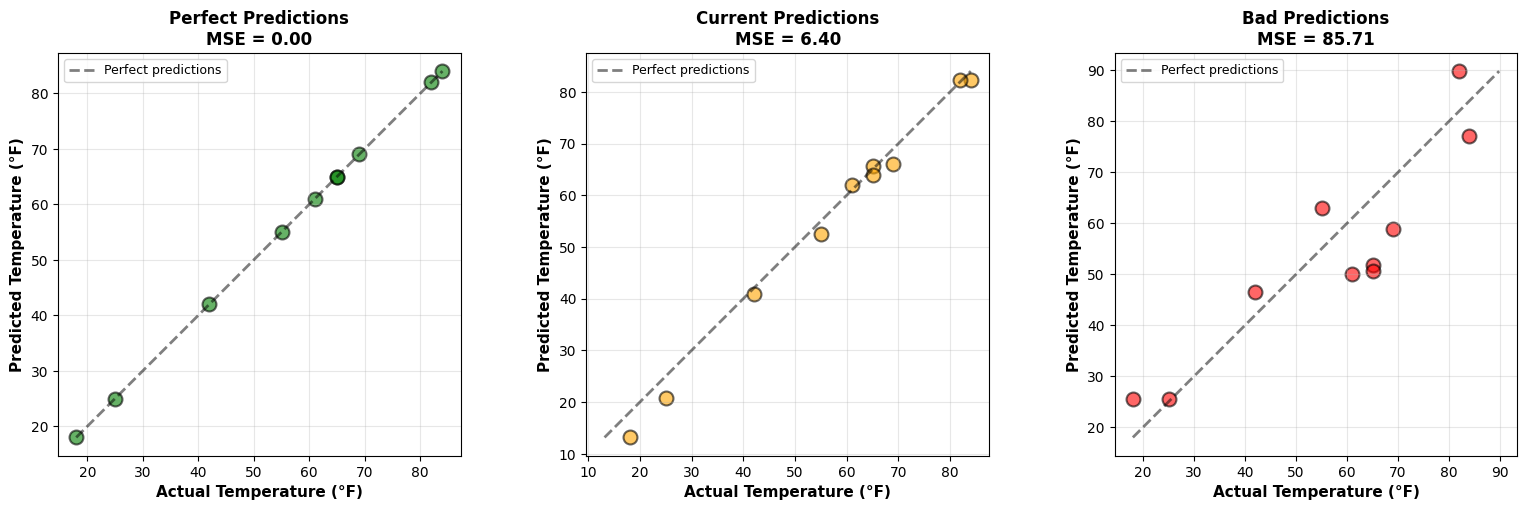


Key observations:
• Perfect predictions: MSE = 0.00 (zero error!)
• Current predictions: MSE = 6.40 (small errors)
• Bad predictions:     MSE = 85.71 (large errors)

Lower MSE = Better predictions. The goal of training is to minimize this number!


In [6]:
# Scenario 1: Perfect predictions (zero error)
perfect_pred = y_true_tensor.clone()
mse_perfect = mse_loss(perfect_pred, y_true_tensor)

# Scenario 2: Our current predictions (small errors)
mse_current = mse_pytorch

# Scenario 3: Bad predictions (large errors, ±15°F)
bad_errors = torch.tensor(np.random.uniform(-15, 15, size=10), dtype=torch.float32)
bad_pred = y_true_tensor + bad_errors
mse_bad = mse_loss(bad_pred, y_true_tensor)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
scenarios = [
    ('Perfect Predictions', perfect_pred, mse_perfect, 'green'),
    ('Current Predictions', y_pred_tensor, mse_current, 'orange'),
    ('Bad Predictions', bad_pred, mse_bad, 'red')
]

for idx, (title, pred, mse_val, color) in enumerate(scenarios):
    ax = axes[idx]
    
    # Plot predicted vs actual
    ax.scatter(y_true_tensor.numpy(), pred.numpy(), 
              c=color, s=100, alpha=0.6, edgecolor='black', linewidth=1.5)
    
    # Add perfect prediction line (diagonal)
    min_val = min(y_true_tensor.min(), pred.min())
    max_val = max(y_true_tensor.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
           'k--', linewidth=2, label='Perfect predictions', alpha=0.5)
    
    ax.set_xlabel('Actual Temperature (°F)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Temperature (°F)', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\nMSE = {mse_val.item():.2f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    
    # Make axes square
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"• Perfect predictions: MSE = {mse_perfect.item():.2f} (zero error!)")
print(f"• Current predictions: MSE = {mse_current.item():.2f} (small errors)")
print(f"• Bad predictions:     MSE = {mse_bad.item():.2f} (large errors)")
print(f"\nLower MSE = Better predictions. The goal of training is to minimize this number!")

> **Reading the plots**: Points on the diagonal line represent perfect predictions (predicted = actual). The further points are from this line, the larger the errors, and the higher the MSE. 
> 
> Notice how MSE grows quickly as errors increase: this is because errors are squared.

## Step 7: Compare MSE vs. other losses for regression

MSE gives us one number, but what does that number actually mean? And why choose MSE over other ways of measuring error? 

Let's compare MSE with related metrics to understand when each one is useful and what information each provides about prediction quality.

In [7]:
# Calculate related metrics for interpretation
mae = torch.abs(y_pred_tensor - y_true_tensor).mean()  # Mean Absolute Error
rmse = torch.sqrt(mse_current)  # Root Mean Squared Error

print("Understanding the MSE value:\n")
print(f"MSE:  {mse_current.item():.2f} (squared degrees)")
print(f"RMSE: {rmse.item():.2f}°F (same units as temperature)")
print(f"MAE:  {mae.item():.2f}°F (average absolute error)\n")

Understanding the MSE value:

MSE:  6.40 (squared degrees)
RMSE: 2.53°F (same units as temperature)
MAE:  2.06°F (average absolute error)



> **Interpreting the numbers**: With RMSE = 2.5°F, predictions are off by about 2.5 degrees on average. For farmers planning frost protection (critical at 32°F), this error could mean the difference between predicting 29.5°F (protect crops!) and 34.5°F (no action needed), crossing a critical threshold. MSE's heavy penalty on big mistakes is exactly what we want for crop planning: it's better to be consistently off by ±2°F than occasionally off by ±10°F. 
> 
> Whether this model is "good enough" depends entirely on the decision being made: acceptable for general temperature trends, but needs improvement for frost-critical decisions.

## Conclusion

Congratulations! You've just implemented and understood your first loss function, the foundation of how neural networks learn.

**What you've learned:**

- [x] **Loss functions measure prediction quality** - They boil all errors down to a single scalar number
- [x] **Squaring matters** - It makes errors positive and penalizes large mistakes more heavily
- [x] **PyTorch does the math** - `nn.MSELoss()` implements the formula, but optimized
- [x] **Lower loss = better predictions** - The goal of training is to minimize this number
- [x] **Choose your loss based on error tolerance** - Use MSE when large errors are genuinely worse (quadratic penalty), MAE when all errors should be weighted equally (linear penalty), ...

> **Key insight**: The loss function is the bridge between "what the model predicts" and "what we want it to predict". It translates prediction quality into a single number that training algorithms can optimize. Without loss functions, we'd have no way to improve models automatically: the model needs that single scalar to know if it's getting better or worse.

##### Next steps to explore:

- [ ] **Experiment with prediction quality**: Try changing `y_pred` values to be closer to or farther from `y_true`. Watch how MSE responds to different error magnitudes.
- [ ] **Compare with other regression losses**: Implement Mean Absolute Error (MAE) and compare how it penalizes errors differently than MSE. Which one is more sensitive to outliers?
- [ ] **Test on different scales**: What happens to MSE if you predict temperature in Celsius instead of Fahrenheit? Does the loss value change? This reveals an important property about MSE being scale-dependent.